In [54]:
import gym
import numpy as np
import tensorflow as tf
env =  gym.make('FrozenLake8x8-v0')# initialize environment
#env =  gym.make('FrozenLake-v0')# initialize environment


[2016-07-04 12:05:53,042] Making new env: FrozenLake8x8-v0


In [89]:
class tf_RL_model:
    def __init__(self):
        self.action_table = {
            'L' : 0,
            'D' : 1,
            'R' : 2,
            'U' : 3
        }
        self.inv_action_table = {v: k for k, v in self.action_table.items()}
        
        # Learning paramters
        self.learning_rate = 0.1
        self.r_prob = 0.5
        self.r_prob_decay = 0.98

    def epsilon_greedy_action(self,state):
        if np.random.rand() < self.r_prob:
            action = env.action_space.sample()
        else:
            action = sess.run(optimal_action, feed_dict={batch_state: [state]})[0]
            #action = np.argmax(SV,1)[0]
        return action
    
    def update_parameters(self,oldstate, newstate, action, reward, done):
        # Get the target values
        if done == False:
            target = reward + 0.99*sess.run(maxQ, 
                     feed_dict = {
                    batch_state : newstate
                })
        else:
            target = reward
        
        
         # Update parameters towards the target value
        sess.run(optimizer, 
                 feed_dict = {
                batch_state : oldstate,
                batch_trueQ : target,
                batch_action : action
            })
        return target
    def get_optimal_policy(self):
        optimal = sess.run(optimal_action, feed_dict = {batch_state : range(env.observation_space.n)
            })
        optimal_name = [ self.inv_action_table[v] for v in optimal]

        return np.reshape(optimal_name,(np.sqrt(env.observation_space.n), np.sqrt(env.observation_space.n)))
    
    def save_trained_policy(self):
        optimal = sess.run(optimal_action, feed_dict = {batch_state : range(env.observation_space.n)
            })
        trained_policy = {}
        for s in range(env.observation_space.n):
            trained_policy[s] = sess.run(optimal_action, feed_dict = {batch_state : [s]})[0]
        self.trained_policy = trained_policy
        
    def epsilon_decay(self):
        self.r_prob *= self.r_prob_decay
        self.r_prob = np.maximum(0.1,self.r_prob) # Never let random probability be less than 5%
    




In [92]:
### TF-MODEL SPECIFICATION
model = tf_RL_model()

graph = tf.Graph()
with graph.as_default():
    batch_state = tf.placeholder(tf.int64, shape = ([None]), name = 'ph_state')
    batch_action = tf.placeholder(tf.int64, shape = ([None]), name = 'ph_action')
    batch_reward = tf.placeholder(tf.float32, shape = ([None]), name = 'ph_reward')
    batch_trueQ = tf.placeholder(tf.float32, shape = ([None]), name = 'ph_trueQ')

    #W = tf.Variable(tf.constant(value = np.linspace(start = 1, stop = env.observation_space.n*env.action_space.n, 
    #                                                num = env.observation_space.n*env.action_space.n, dtype='float32'), 
    #                shape = [env.observation_space.n, env.action_space.n]
    #               ))
    W = tf.get_variable(shape = [env.observation_space.n, env.action_space.n],
            initializer = tf.random_normal_initializer(mean=0, stddev= 0.1) , name = 'policy')  
    # One hot vectors of state and action indicies:
                        
    state = tf.one_hot(indices = batch_state,
                           depth = env.observation_space.n,
                          on_value = 1.0, off_value = 0.0)
    
    action = tf.one_hot(indices = batch_action,
                           depth = env.action_space.n,
                          on_value = 1.0, off_value = 0.0)
    
    Qval = tf.matmul(state,W) #Q_function(state)
    
    optimal_action = tf.argmax(Qval,1)
    
    maxQ = tf.reduce_max(Qval,1)
    
    Q_a = tf.reduce_sum(tf.mul(Qval, action),1) # only get non-zero chosen actions
    loss = tf.nn.l2_loss( batch_trueQ - Q_a)
    optimizer = tf.train.GradientDescentOptimizer(model.learning_rate).minimize(loss)

In [93]:
sess = tf.Session(graph=graph)
with sess as session:
    sess.run(tf.initialize_all_variables())


    # Probability of random action
    #
    model.r_prob_decay = 0.99995
    model.learning_rate = 0.1

    # Logging variables
    visits = np.zeros([env.observation_space.n])

    run_reward = [] # running average initialize
    num_episodes = 60000 # Total number of games
    #old_optimal = model.get_optimal_policy() # Initial optimal strategy
    
    newweight = sess.run(tf.trainable_variables())[0]
    for n in xrange(num_episodes + 1):
        newstate = env.reset()
        done = False

        for ep in xrange(200):
            # Current state
            oldstate = newstate
            # Perform epsilon-greedy action:
            action = model.epsilon_greedy_action(oldstate)
            # Take action and observe state and reward
            newstate, reward, done, info = env.step(action)
            visits[newstate] += 1

            # Reward modifications:
            # if (done is True and reward == 0):
            #    reward = -0.2
            # reward -= 0.01 # cost of life
            
            
            # Update parameters
            tQ = model.update_parameters([oldstate], [newstate], [action], [reward],done) # brackets fordi det er enkelttall inn
            
            # Debugging:
            if False:
                oldweight = newweight
                newweight = sess.run(tf.trainable_variables())[0]
                diff = newweight - oldweight
                print 'old: ' + str(oldstate) + '\t new: ' + str(newstate) +\
                '\t a: ' + str(action) + '\t r: ' + str(reward) +\
                '\t targetQ: ' + str(np.round(tQ[0],3)) + '\t Qval: ' + str(np.round(oldweight[oldstate,action],3)) + '\t Qdiff: ' + str(np.round(diff[oldstate,action],3)) 

            
            if done:
                break
            
            # print 'episode ' + str(n) + 'reached maximum steps. skipping...'

        # Decay epsilon
        model.epsilon_decay()
        run_reward.append(reward)

        if n % int(num_episodes/20) == 0:
            
            run_avg = np.mean(run_reward)
            run_reward = []
            print 'step: ' + str(n) + ' \t r_prob:' + str(np.round(model.r_prob,2)) + '\t run_avg: ' + str(np.round(run_avg,3))
            print model.get_optimal_policy()
            #print sess.run(tf.trainable_variables())[0]
    model.save_trained_policy()

step: 0 	 r_prob:0.5	 run_avg: 0.0
[['R' 'U' 'U' 'R' 'U' 'R' 'U' 'L']
 ['D' 'D' 'D' 'U' 'D' 'D' 'L' 'R']
 ['R' 'D' 'U' 'D' 'U' 'U' 'U' 'D']
 ['D' 'D' 'D' 'R' 'U' 'U' 'D' 'U']
 ['L' 'R' 'R' 'U' 'L' 'R' 'L' 'R']
 ['D' 'U' 'L' 'R' 'D' 'R' 'L' 'L']
 ['R' 'L' 'L' 'D' 'U' 'R' 'D' 'D']
 ['R' 'D' 'R' 'R' 'D' 'U' 'L' 'D']]
step: 3000 	 r_prob:0.43	 run_avg: 0.06
[['D' 'R' 'U' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'R' 'D']
 ['U' 'U' 'L' 'D' 'R' 'U' 'R' 'L']
 ['U' 'U' 'L' 'U' 'U' 'U' 'R' 'R']
 ['U' 'U' 'L' 'U' 'R' 'D' 'U' 'R']
 ['L' 'U' 'L' 'R' 'U' 'R' 'L' 'R']
 ['R' 'L' 'L' 'U' 'U' 'L' 'D' 'R']
 ['R' 'D' 'R' 'R' 'D' 'U' 'R' 'D']]
step: 6000 	 r_prob:0.37	 run_avg: 0.107
[['D' 'R' 'R' 'R' 'D' 'R' 'R' 'L']
 ['U' 'U' 'U' 'U' 'U' 'D' 'R' 'D']
 ['U' 'U' 'L' 'D' 'R' 'U' 'R' 'R']
 ['U' 'L' 'U' 'U' 'L' 'U' 'R' 'R']
 ['U' 'U' 'U' 'U' 'R' 'D' 'U' 'R']
 ['L' 'U' 'L' 'R' 'U' 'L' 'L' 'R']
 ['R' 'L' 'L' 'U' 'U' 'R' 'D' 'R']
 ['R' 'D' 'R' 'R' 'D' 'U' 'R' 'D']]
step: 9000 	 r_prob:0.32	 run_avg: 0.142


KeyboardInterrupt: 

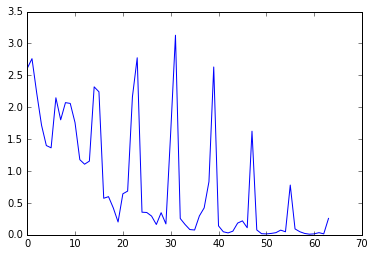

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

# Number of visits per episode:
plt.plot(visits/num_episodes)
#num_episodes/visits

### Test Run

In [72]:
passive_policy = {
    0 : 2,
    1 : 2,
    2 : 2,
    3 : 2,
    4 : 2,
    5 : 2,
    6 : 2,
    7 : 1,
    8 : 3,
    9:3,
    10:3,
    11:3,
    12:3,
    13:3,
    14:3,
    15:2,
    23:2,
    31:2,
    39:2,
    47:2,
    55:2,
    64:2
}

In [86]:
env.monitor.start('recordings', force=True)
num_episodes = 1000
R = []


def moving_average(a, n = 100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


model.r_prob = 0 # ensure that only the optimal solution is used

for n in xrange(num_episodes):
    newstate = env.reset()
    done = False
    k = 0
    while not done:
        # Current state
        oldstate = newstate
        
        # Perform epsilon-greedy action:
        action = model.trained_policy[oldstate]
        #action = passive_policy[oldstate]
        # Take action and observe state and reward
        newstate, reward, done, info = env.step(action)
        k += 1
    R.append(reward)
    print 'Episode: ' + str(n) +'\t steps: ' + str(k) + '\t state: ' + str(newstate), '\t reward: ' + str(reward)
    #if n % 1000 == 101:
    #    MA = np.max(moving_average(R))
    #    print 'step: ' + str(n) + '\t MRA: ' + str(MA)
    #    if MA > 0.99:
    #        break
env.monitor.close()

[2016-07-04 14:06:09,705] Clearing 12 monitor files from previous run (because force=True was provided)
[2016-07-04 14:06:09,707] Starting new video recorder writing to /notebooks/hjem/RL/recordings/openaigym.video.15.19815.video000000.json
[2016-07-04 14:06:09,714] Starting new video recorder writing to /notebooks/hjem/RL/recordings/openaigym.video.15.19815.video000001.json
[2016-07-04 14:06:09,731] Starting new video recorder writing to /notebooks/hjem/RL/recordings/openaigym.video.15.19815.video000008.json
[2016-07-04 14:06:09,785] Starting new video recorder writing to /notebooks/hjem/RL/recordings/openaigym.video.15.19815.video000027.json
[2016-07-04 14:06:09,826] Ending episode 44 because it reached the timestep limit of 200.
[2016-07-04 14:06:09,874] Starting new video recorder writing to /notebooks/hjem/RL/recordings/openaigym.video.15.19815.video000064.json
[2016-07-04 14:06:09,888] Ending episode 67 because it reached the timestep limit of 200.


Episode: 0	 steps: 45	 state: 54 	 reward: 0.0
Episode: 1	 steps: 88	 state: 54 	 reward: 0.0
Episode: 2	 steps: 69	 state: 63 	 reward: 1.0
Episode: 3	 steps: 67	 state: 42 	 reward: 0.0
Episode: 4	 steps: 108	 state: 63 	 reward: 1.0
Episode: 5	 steps: 42	 state: 19 	 reward: 0.0
Episode: 6	 steps: 62	 state: 35 	 reward: 0.0
Episode: 7	 steps: 15	 state: 19 	 reward: 0.0
Episode: 8	 steps: 150	 state: 63 	 reward: 1.0
Episode: 9	 steps: 50	 state: 63 	 reward: 1.0
Episode: 10	 steps: 53	 state: 63 	 reward: 1.0
Episode: 11	 steps: 39	 state: 63 	 reward: 1.0
Episode: 12	 steps: 30	 state: 63 	 reward: 1.0
Episode: 13	 steps: 86	 state: 63 	 reward: 1.0
Episode: 14	 steps: 68	 state: 63 	 reward: 1.0
Episode: 15	 steps: 40	 state: 63 	 reward: 1.0
Episode: 16	 steps: 54	 state: 63 	 reward: 1.0
Episode: 17	 steps: 47	 state: 63 	 reward: 1.0
Episode: 18	 steps: 36	 state: 63 	 reward: 1.0
Episode: 19	 steps: 76	 state: 63 	 reward: 1.0
Episode: 20	 steps: 67	 state: 63 	 reward: 1.0


[2016-07-04 14:06:10,009] Starting new video recorder writing to /notebooks/hjem/RL/recordings/openaigym.video.15.19815.video000125.json


Episode: 77	 steps: 22	 state: 19 	 reward: 0.0
Episode: 78	 steps: 84	 state: 63 	 reward: 1.0
Episode: 79	 steps: 107	 state: 63 	 reward: 1.0
Episode: 80	 steps: 22	 state: 63 	 reward: 1.0
Episode: 81	 steps: 81	 state: 19 	 reward: 0.0
Episode: 82	 steps: 48	 state: 63 	 reward: 1.0
Episode: 83	 steps: 78	 state: 42 	 reward: 0.0
Episode: 84	 steps: 6	 state: 19 	 reward: 0.0
Episode: 85	 steps: 33	 state: 42 	 reward: 0.0
Episode: 86	 steps: 29	 state: 19 	 reward: 0.0
Episode: 87	 steps: 9	 state: 35 	 reward: 0.0
Episode: 88	 steps: 10	 state: 19 	 reward: 0.0
Episode: 89	 steps: 10	 state: 19 	 reward: 0.0
Episode: 90	 steps: 44	 state: 42 	 reward: 0.0
Episode: 91	 steps: 76	 state: 42 	 reward: 0.0
Episode: 92	 steps: 14	 state: 19 	 reward: 0.0
Episode: 93	 steps: 69	 state: 63 	 reward: 1.0
Episode: 94	 steps: 11	 state: 19 	 reward: 0.0
Episode: 95	 steps: 42	 state: 63 	 reward: 1.0
Episode: 96	 steps: 8	 state: 19 	 reward: 0.0
Episode: 97	 steps: 66	 state: 54 	 reward

[2016-07-04 14:06:10,243] Starting new video recorder writing to /notebooks/hjem/RL/recordings/openaigym.video.15.19815.video000216.json


Episode: 171	 steps: 44	 state: 63 	 reward: 1.0
Episode: 172	 steps: 74	 state: 63 	 reward: 1.0
Episode: 173	 steps: 47	 state: 63 	 reward: 1.0
Episode: 174	 steps: 56	 state: 63 	 reward: 1.0
Episode: 175	 steps: 12	 state: 19 	 reward: 0.0
Episode: 176	 steps: 75	 state: 63 	 reward: 1.0
Episode: 177	 steps: 69	 state: 63 	 reward: 1.0
Episode: 178	 steps: 124	 state: 63 	 reward: 1.0
Episode: 179	 steps: 24	 state: 63 	 reward: 1.0
Episode: 180	 steps: 40	 state: 54 	 reward: 0.0
Episode: 181	 steps: 89	 state: 63 	 reward: 1.0
Episode: 182	 steps: 16	 state: 19 	 reward: 0.0
Episode: 183	 steps: 41	 state: 35 	 reward: 0.0
Episode: 184	 steps: 21	 state: 19 	 reward: 0.0
Episode: 185	 steps: 82	 state: 63 	 reward: 1.0
Episode: 186	 steps: 41	 state: 35 	 reward: 0.0
Episode: 187	 steps: 50	 state: 63 	 reward: 1.0
Episode: 188	 steps: 67	 state: 63 	 reward: 1.0
Episode: 189	 steps: 77	 state: 63 	 reward: 1.0
Episode: 190	 steps: 25	 state: 63 	 reward: 1.0
Episode: 191	 steps

[2016-07-04 14:06:10,354] Ending episode 250 because it reached the timestep limit of 200.
[2016-07-04 14:06:10,373] Ending episode 259 because it reached the timestep limit of 200.


Episode: 238	 steps: 13	 state: 19 	 reward: 0.0
Episode: 239	 steps: 32	 state: 63 	 reward: 1.0
Episode: 240	 steps: 90	 state: 63 	 reward: 1.0
Episode: 241	 steps: 65	 state: 63 	 reward: 1.0
Episode: 242	 steps: 16	 state: 35 	 reward: 0.0
Episode: 243	 steps: 51	 state: 63 	 reward: 1.0
Episode: 244	 steps: 88	 state: 63 	 reward: 1.0
Episode: 245	 steps: 22	 state: 35 	 reward: 0.0
Episode: 246	 steps: 22	 state: 63 	 reward: 1.0
Episode: 247	 steps: 31	 state: 63 	 reward: 1.0
Episode: 248	 steps: 13	 state: 19 	 reward: 0.0
Episode: 249	 steps: 200	 state: 63 	 reward: 1.0
Episode: 250	 steps: 70	 state: 35 	 reward: 0.0
Episode: 251	 steps: 53	 state: 63 	 reward: 1.0
Episode: 252	 steps: 57	 state: 63 	 reward: 1.0
Episode: 253	 steps: 25	 state: 54 	 reward: 0.0
Episode: 254	 steps: 29	 state: 63 	 reward: 1.0
Episode: 255	 steps: 50	 state: 19 	 reward: 0.0
Episode: 256	 steps: 45	 state: 63 	 reward: 1.0
Episode: 257	 steps: 7	 state: 19 	 reward: 0.0
Episode: 258	 steps:

[2016-07-04 14:06:10,628] Ending episode 337 because it reached the timestep limit of 200.
[2016-07-04 14:06:10,643] Starting new video recorder writing to /notebooks/hjem/RL/recordings/openaigym.video.15.19815.video000343.json


Episode: 308	 steps: 78	 state: 63 	 reward: 1.0
Episode: 309	 steps: 143	 state: 54 	 reward: 0.0
Episode: 310	 steps: 63	 state: 42 	 reward: 0.0
Episode: 311	 steps: 98	 state: 63 	 reward: 1.0
Episode: 312	 steps: 85	 state: 63 	 reward: 1.0
Episode: 313	 steps: 19	 state: 19 	 reward: 0.0
Episode: 314	 steps: 63	 state: 63 	 reward: 1.0
Episode: 315	 steps: 14	 state: 19 	 reward: 0.0
Episode: 316	 steps: 59	 state: 63 	 reward: 1.0
Episode: 317	 steps: 10	 state: 19 	 reward: 0.0
Episode: 318	 steps: 46	 state: 63 	 reward: 1.0
Episode: 319	 steps: 114	 state: 63 	 reward: 1.0
Episode: 320	 steps: 27	 state: 19 	 reward: 0.0
Episode: 321	 steps: 25	 state: 35 	 reward: 0.0
Episode: 322	 steps: 13	 state: 19 	 reward: 0.0
Episode: 323	 steps: 68	 state: 35 	 reward: 0.0
Episode: 324	 steps: 54	 state: 63 	 reward: 1.0
Episode: 325	 steps: 49	 state: 63 	 reward: 1.0
Episode: 326	 steps: 32	 state: 63 	 reward: 1.0
Episode: 327	 steps: 91	 state: 63 	 reward: 1.0
Episode: 328	 step

[2016-07-04 14:06:10,867] Ending episode 399 because it reached the timestep limit of 200.


Episode: 359	 steps: 167	 state: 42 	 reward: 0.0
Episode: 360	 steps: 24	 state: 19 	 reward: 0.0
Episode: 361	 steps: 21	 state: 35 	 reward: 0.0
Episode: 362	 steps: 8	 state: 19 	 reward: 0.0
Episode: 363	 steps: 17	 state: 19 	 reward: 0.0
Episode: 364	 steps: 54	 state: 63 	 reward: 1.0
Episode: 365	 steps: 96	 state: 63 	 reward: 1.0
Episode: 366	 steps: 12	 state: 19 	 reward: 0.0
Episode: 367	 steps: 116	 state: 63 	 reward: 1.0
Episode: 368	 steps: 18	 state: 35 	 reward: 0.0
Episode: 369	 steps: 117	 state: 42 	 reward: 0.0
Episode: 370	 steps: 23	 state: 63 	 reward: 1.0
Episode: 371	 steps: 68	 state: 42 	 reward: 0.0
Episode: 372	 steps: 43	 state: 63 	 reward: 1.0
Episode: 373	 steps: 37	 state: 63 	 reward: 1.0
Episode: 374	 steps: 6	 state: 19 	 reward: 0.0
Episode: 375	 steps: 38	 state: 42 	 reward: 0.0
Episode: 376	 steps: 37	 state: 63 	 reward: 1.0
Episode: 377	 steps: 95	 state: 63 	 reward: 1.0
Episode: 378	 steps: 32	 state: 54 	 reward: 0.0
Episode: 379	 steps

[2016-07-04 14:06:11,319] Starting new video recorder writing to /notebooks/hjem/RL/recordings/openaigym.video.15.19815.video000512.json


Episode: 470	 steps: 86	 state: 54 	 reward: 0.0
Episode: 471	 steps: 6	 state: 19 	 reward: 0.0
Episode: 472	 steps: 83	 state: 54 	 reward: 0.0
Episode: 473	 steps: 9	 state: 19 	 reward: 0.0
Episode: 474	 steps: 6	 state: 19 	 reward: 0.0
Episode: 475	 steps: 15	 state: 35 	 reward: 0.0
Episode: 476	 steps: 61	 state: 63 	 reward: 1.0
Episode: 477	 steps: 93	 state: 63 	 reward: 1.0
Episode: 478	 steps: 43	 state: 19 	 reward: 0.0
Episode: 479	 steps: 98	 state: 63 	 reward: 1.0
Episode: 480	 steps: 10	 state: 35 	 reward: 0.0
Episode: 481	 steps: 106	 state: 63 	 reward: 1.0
Episode: 482	 steps: 67	 state: 63 	 reward: 1.0
Episode: 483	 steps: 15	 state: 19 	 reward: 0.0
Episode: 484	 steps: 47	 state: 63 	 reward: 1.0
Episode: 485	 steps: 90	 state: 19 	 reward: 0.0
Episode: 486	 steps: 54	 state: 63 	 reward: 1.0
Episode: 487	 steps: 27	 state: 63 	 reward: 1.0
Episode: 488	 steps: 84	 state: 63 	 reward: 1.0
Episode: 489	 steps: 72	 state: 63 	 reward: 1.0
Episode: 490	 steps: 1

[2016-07-04 14:06:12,039] Ending episode 680 because it reached the timestep limit of 200.


Episode: 665	 steps: 32	 state: 19 	 reward: 0.0
Episode: 666	 steps: 15	 state: 19 	 reward: 0.0
Episode: 667	 steps: 17	 state: 19 	 reward: 0.0
Episode: 668	 steps: 45	 state: 63 	 reward: 1.0
Episode: 669	 steps: 47	 state: 63 	 reward: 1.0
Episode: 670	 steps: 60	 state: 63 	 reward: 1.0
Episode: 671	 steps: 5	 state: 19 	 reward: 0.0
Episode: 672	 steps: 49	 state: 35 	 reward: 0.0
Episode: 673	 steps: 83	 state: 63 	 reward: 1.0
Episode: 674	 steps: 50	 state: 42 	 reward: 0.0
Episode: 675	 steps: 70	 state: 63 	 reward: 1.0
Episode: 676	 steps: 177	 state: 63 	 reward: 1.0
Episode: 677	 steps: 83	 state: 54 	 reward: 0.0
Episode: 678	 steps: 50	 state: 63 	 reward: 1.0
Episode: 679	 steps: 200	 state: 31 	 reward: 0.0
Episode: 680	 steps: 13	 state: 19 	 reward: 0.0
Episode: 681	 steps: 52	 state: 63 	 reward: 1.0
Episode: 682	 steps: 125	 state: 63 	 reward: 1.0
Episode: 683	 steps: 52	 state: 54 	 reward: 0.0
Episode: 684	 steps: 33	 state: 63 	 reward: 1.0
Episode: 685	 step

[2016-07-04 14:06:12,236] Starting new video recorder writing to /notebooks/hjem/RL/recordings/openaigym.video.15.19815.video000729.json


Episode: 709	 steps: 41	 state: 54 	 reward: 0.0
Episode: 710	 steps: 57	 state: 63 	 reward: 1.0
Episode: 711	 steps: 52	 state: 63 	 reward: 1.0
Episode: 712	 steps: 42	 state: 54 	 reward: 0.0
Episode: 713	 steps: 37	 state: 42 	 reward: 0.0
Episode: 714	 steps: 62	 state: 63 	 reward: 1.0
Episode: 715	 steps: 71	 state: 63 	 reward: 1.0
Episode: 716	 steps: 36	 state: 63 	 reward: 1.0
Episode: 717	 steps: 99	 state: 63 	 reward: 1.0
Episode: 718	 steps: 77	 state: 63 	 reward: 1.0
Episode: 719	 steps: 49	 state: 63 	 reward: 1.0
Episode: 720	 steps: 52	 state: 19 	 reward: 0.0
Episode: 721	 steps: 44	 state: 42 	 reward: 0.0
Episode: 722	 steps: 95	 state: 63 	 reward: 1.0
Episode: 723	 steps: 36	 state: 63 	 reward: 1.0
Episode: 724	 steps: 52	 state: 54 	 reward: 0.0
Episode: 725	 steps: 61	 state: 63 	 reward: 1.0
Episode: 726	 steps: 42	 state: 63 	 reward: 1.0
Episode: 727	 steps: 5	 state: 19 	 reward: 0.0
Episode: 728	 steps: 90	 state: 63 	 reward: 1.0
Episode: 729	 steps: 

[2016-07-04 14:06:12,774] Ending episode 812 because it reached the timestep limit of 200.


Episode: 783	 steps: 10	 state: 19 	 reward: 0.0
Episode: 784	 steps: 27	 state: 19 	 reward: 0.0
Episode: 785	 steps: 52	 state: 63 	 reward: 1.0
Episode: 786	 steps: 137	 state: 63 	 reward: 1.0
Episode: 787	 steps: 6	 state: 19 	 reward: 0.0
Episode: 788	 steps: 141	 state: 63 	 reward: 1.0
Episode: 789	 steps: 115	 state: 63 	 reward: 1.0
Episode: 790	 steps: 94	 state: 19 	 reward: 0.0
Episode: 791	 steps: 37	 state: 63 	 reward: 1.0
Episode: 792	 steps: 13	 state: 19 	 reward: 0.0
Episode: 793	 steps: 71	 state: 63 	 reward: 1.0
Episode: 794	 steps: 143	 state: 63 	 reward: 1.0
Episode: 795	 steps: 70	 state: 54 	 reward: 0.0
Episode: 796	 steps: 50	 state: 63 	 reward: 1.0
Episode: 797	 steps: 93	 state: 63 	 reward: 1.0
Episode: 798	 steps: 47	 state: 63 	 reward: 1.0
Episode: 799	 steps: 84	 state: 63 	 reward: 1.0
Episode: 800	 steps: 9	 state: 19 	 reward: 0.0
Episode: 801	 steps: 16	 state: 19 	 reward: 0.0
Episode: 802	 steps: 17	 state: 19 	 reward: 0.0
Episode: 803	 step

[2016-07-04 14:06:14,050] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/hjem/RL/recordings')


Episode: 995	 steps: 50	 state: 63 	 reward: 1.0
Episode: 996	 steps: 17	 state: 19 	 reward: 0.0
Episode: 997	 steps: 9	 state: 19 	 reward: 0.0
Episode: 998	 steps: 10	 state: 19 	 reward: 0.0
Episode: 999	 steps: 14	 state: 19 	 reward: 0.0


0.61


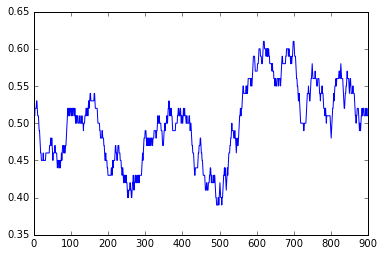

In [87]:
MV = moving_average(R, n = 100)
print np.max(MV)

plt.plot(MV)

In [ ]:
gym.upload('/notebooks/hjem/RL/recordings', api_key='sk_znZbtlUTlu1nJNqFLRIyA')

In [ ]:
env.monitor.close()
